100%|██████████| 198/198 [00:09<00:00, 21.48it/s]


1566
target_participant
ejaz        174
asfik       174
anam        174
unk1        174
iftakhar    174
tonmoy      174
ritwik      174
alsaad      174
twp5        174
Name: count, dtype: int64
mode
target_only                567
target_only_fine_tuning    567
full_fine_tuning           405
base                        27
Name: count, dtype: int64
target_data_pct
1.000    432
0.010    243
0.250    243
0.125    243
0.500    243
0.001    162
Name: count, dtype: int64


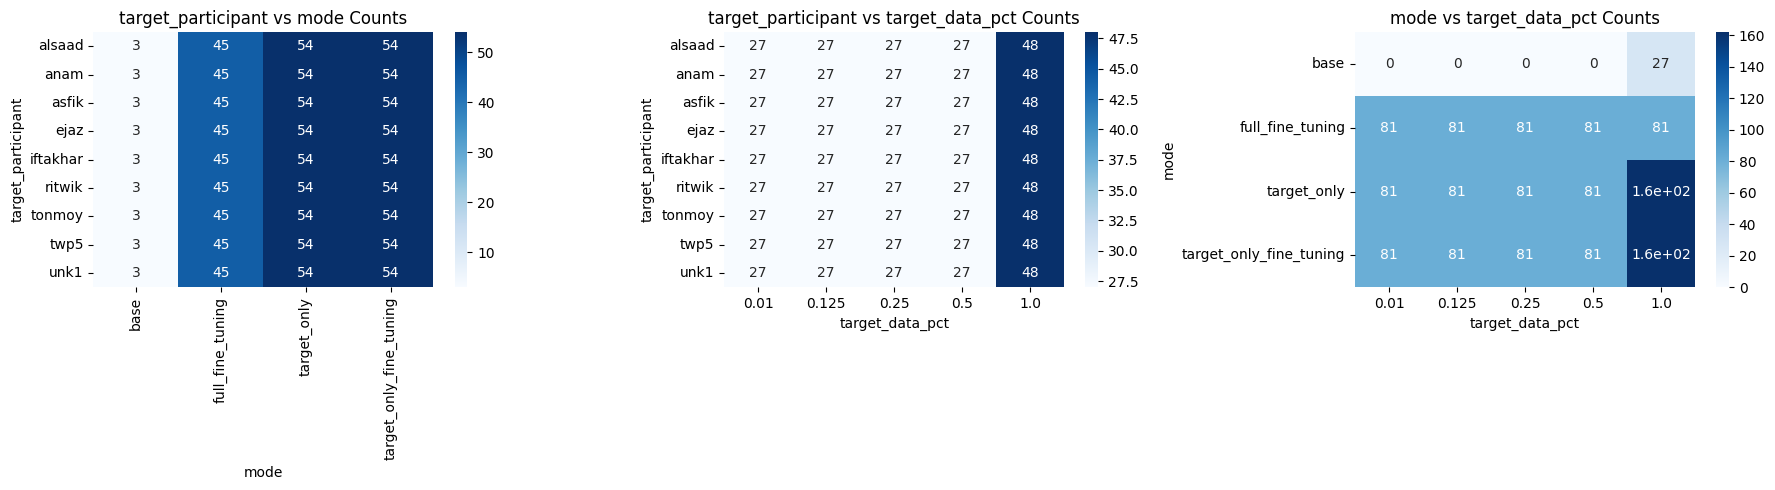

In [15]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1, plot_hyperparameter_counts, load_experiments_from_dir

experiments_dir = f'./experiments'

df = load_experiments_from_dir(experiments_dir, device='cuda')
print(len(df))
hyperparameters_to_plot = ['target_participant', 'mode','target_data_pct']
for hp in hyperparameters_to_plot:
    print(df[hp].value_counts())


def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

def get_base_val_f1(row):
    if row['mode'] == 'base':
        return row['target_val_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['target_val_f1'].iloc[0] if len(base_row) > 0 else None
    
df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['base_target_val_f1'] = df.apply(get_base_val_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']
df['relative_improvement'] = df['absolute_improvement'] / df['base_test_f1']
df['room_for_improvement'] = 1.0 - df['base_test_f1']
df['relative_to_room_for_improvement'] = df['absolute_improvement'] / df['room_for_improvement']

df['absolute_improvement_val'] = df['best_val_f1'] - df['base_target_val_f1']
df['relative_improvement_val'] = df['absolute_improvement_val'] / df['base_target_val_f1']
df['room_for_improvement_val'] = 1.0 - df['base_target_val_f1']
df['relative_to_room_for_improvement_val'] = df['absolute_improvement_val'] / df['room_for_improvement_val']

df = df[df['target_data_pct'] != .001]
plot_hyperparameter_counts(df, hyperparameters_to_plot)

Models trained on a population of individuals perform quite well within distribution (meaning on the individuals it was trained on)

(0.0, 1.0)

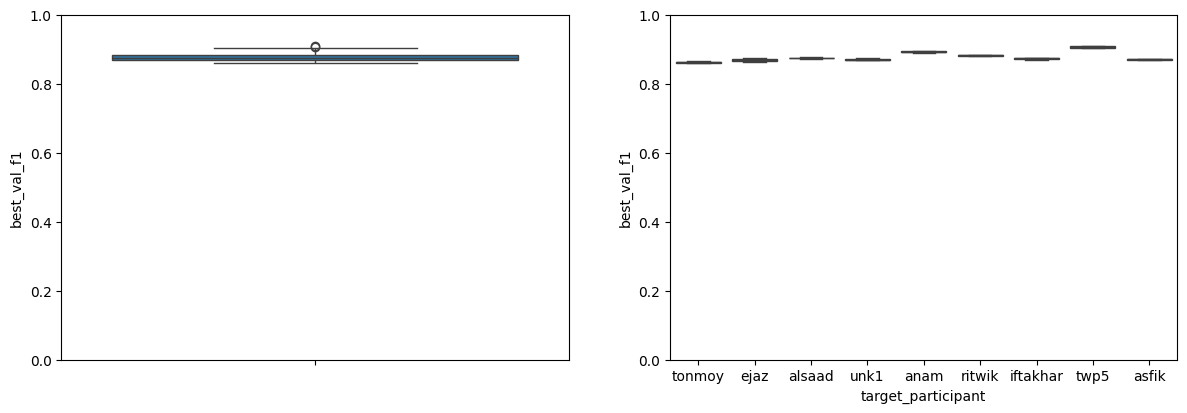

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df[df['mode'] == 'base'], y='best_val_f1', ax=ax[0])
sns.boxplot(data=df[df['mode'] == 'base'], x='target_participant', y='best_val_f1', ax=ax[1])

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

However, performance of population models on participants out of distribution varies widely

(0.0, 1.0)

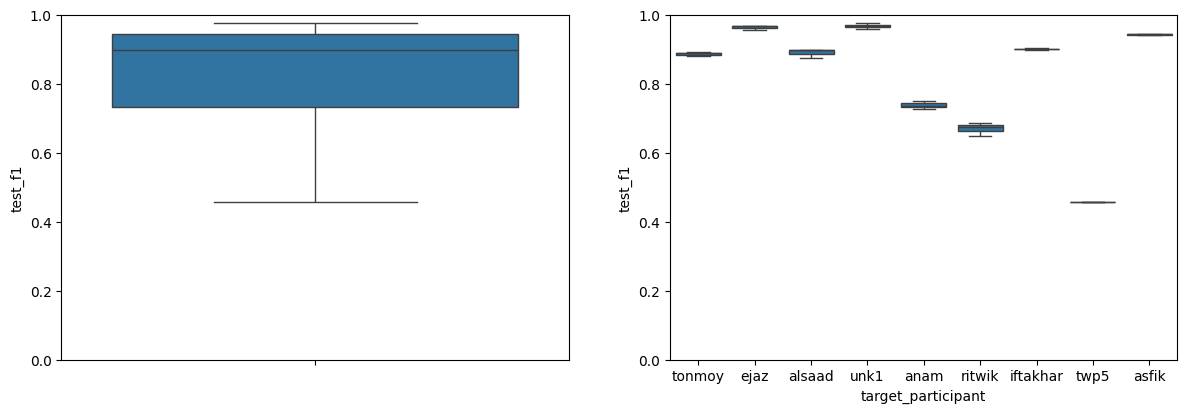

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df[df['mode'] == 'base'], y='test_f1', ax=ax[0])
sns.boxplot(data=df[df['mode'] == 'base'], x='target_participant', y='test_f1', ax=ax[1])

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

Here is the same plot with the performance of population models in distribution and out of distribution side by side

In [4]:
df_melted = df.melt(id_vars=['mode','target_participant'], value_vars=['best_val_f1','test_f1'])

<Axes: xlabel='variable', ylabel='value'>

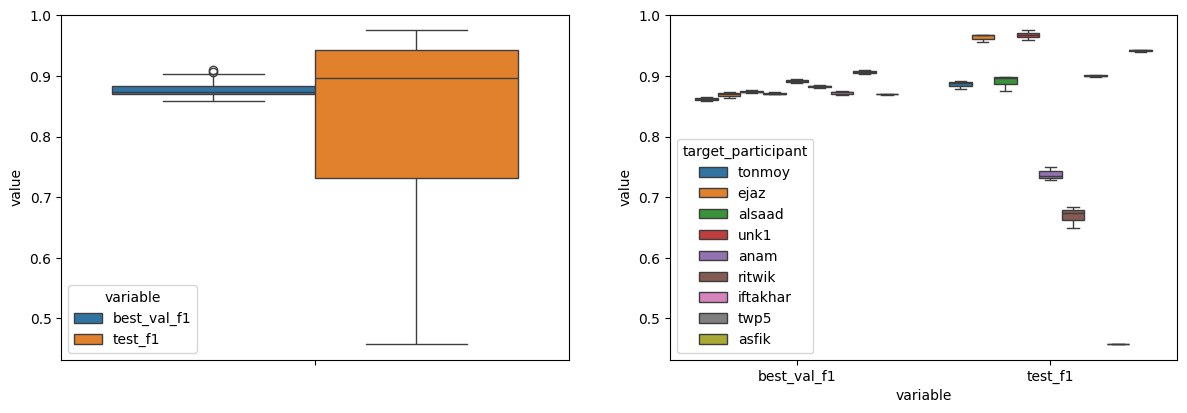

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14.4, 4.48),dpi=100)

sns.boxplot(data=df_melted[df_melted['mode'] == 'base'], y='value', hue='variable', ax=ax[0])
sns.boxplot(data=df_melted[df_melted['mode'] == 'base'], x='variable', y='value', hue='target_participant', ax=ax[1])

Our goal is to develop a method that performs better on individuals out of distribution. Idea: fine tune population model on data from the data.

Here is a plot of the performance of a base model and a fine tuned model on a target

<Axes: xlabel='mode', ylabel='test_f1'>

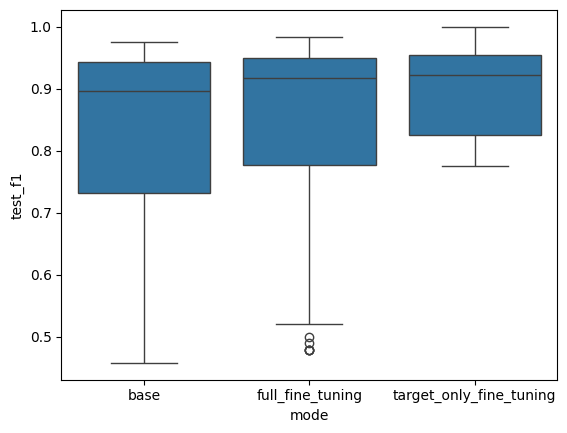

In [6]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='test_f1')

So, our method tightens performance distribution and shifts upward. By how much? Let's call the difference between the fine tuned model and the base model the absolute improvement.

<Axes: xlabel='mode', ylabel='absolute_improvement_val'>

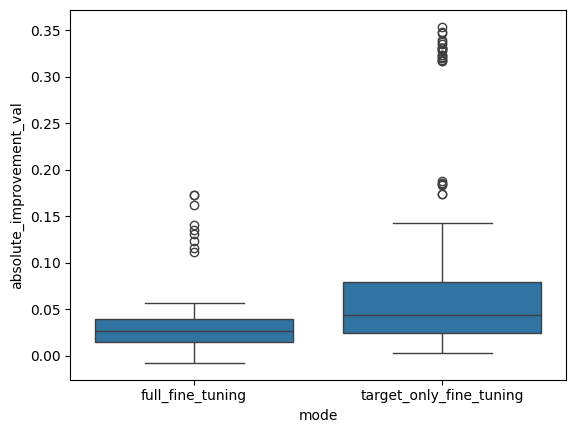

In [7]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['mode'] != 'base']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='absolute_improvement_val')

So there is the absolute improvement. Of course the base model doesn't improve over the base model, so that distribution is 0. But the target fine tuning model performance (across a distribution of random seeds and folds for cross validation) has significant absolute improvement. Now, this is ABSOLUTE improvement. What if a base model is ALREADY performing well? Then there is not much room for improvement. Let's define the absolute improvement as a proportion of that room for improvement as relative room for improvement.

<Axes: xlabel='mode', ylabel='relative_to_room_for_improvement_val'>

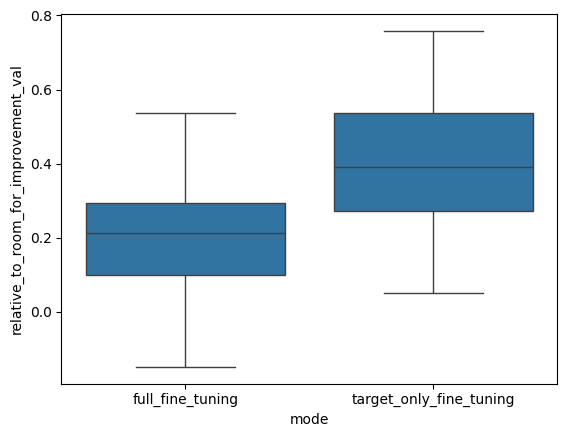

In [8]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['mode'] != 'base']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='relative_to_room_for_improvement_val')

So, on average we are recovering 40% of the relative room for improvement. For example, if a model starts with .5 f1, we increase that to .7. And if a base model performs with .9 f1, then we increase that to .94.

So, target only fine tuning improves signficantly over the base model, but that seems expected sort of. So why not just train a model from scratch only on the target's training set? Then you don't have to have a population model.

<Axes: xlabel='mode', ylabel='test_f1'>

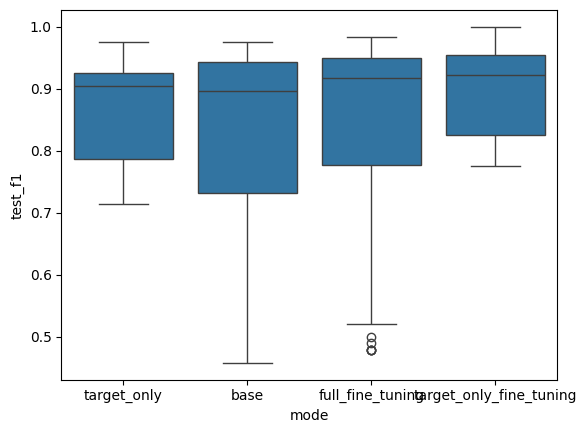

In [9]:
df_plot = df.copy()
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot,x='mode',y='test_f1')

Well, it may work to a satisfying performance, arguably better than the population model, but still worse than the fine tuned model. So there is a tradeoff between whether you have a population model and the performance you want to achieve. There is another parameter which is implicit here which is the _amount_ of target data you have available to you.

<Axes: xlabel='mode', ylabel='test_f1'>

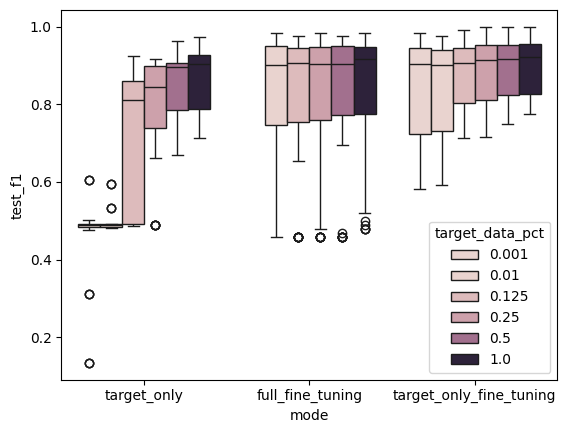

In [10]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'base']
sns.boxplot(data=df_plot,x='mode',y='test_f1',hue='target_data_pct')

<Axes: xlabel='target_data_pct', ylabel='test_f1'>

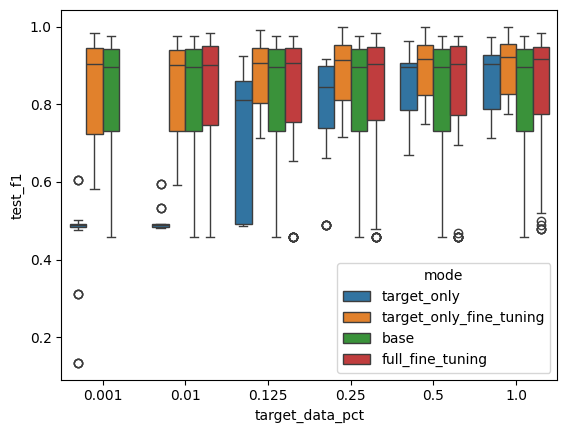

In [11]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.001, .01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

sns.boxplot(data=df_plot,x='target_data_pct',y='test_f1',hue='mode')

<Axes: xlabel='mode', ylabel='test_f1'>

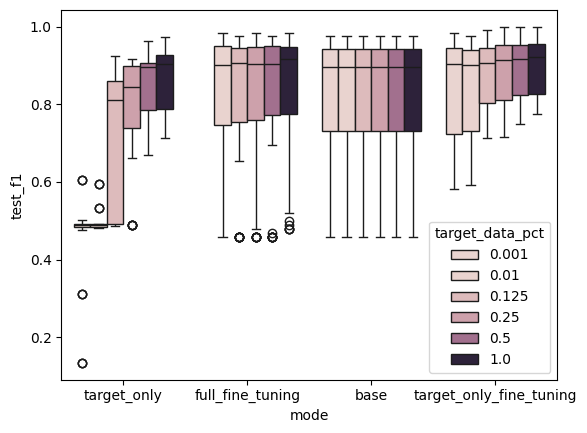

In [12]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.001, .01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

sns.boxplot(data=df_plot,x='mode',y='test_f1',hue='target_data_pct')

<Axes: xlabel='target_data_pct', ylabel='test_f1'>

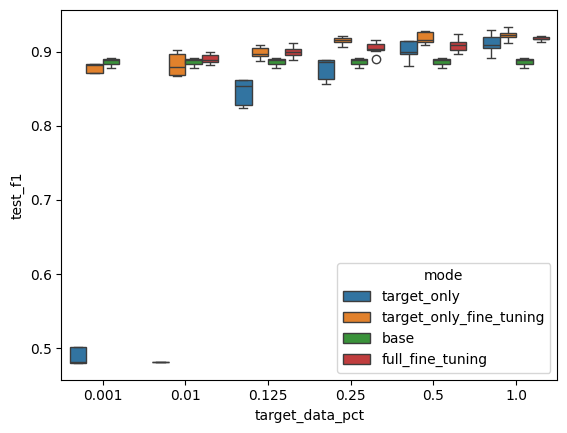

In [13]:
df_plot = df.copy()
df_tmp = df.copy()

for target_data_pct in [.001, .01, .125, .25, .5]:
    df_tmp.loc[df_tmp['mode'] == 'base','target_data_pct'] = target_data_pct
    df_tmp = df_tmp[df_tmp['mode'] == 'base']
    df_plot = pd.concat([df_plot, df_tmp])

df_plot = df_plot[df_plot['fold'] == 0]
sns.boxplot(data=df_plot,x='target_data_pct',y='test_f1',hue='mode')

Pick the best model based on validation performance

0.8128221995646729
0.894641289517433
0.8949903733999263


,base_experiment_prefix,best_val_loss,best_val_loss_epoch,best_val_f1,best_val_f1_epoch,total_epochs,test_loss,test_f1,fold,device,...,base_test_f1,base_target_val_f1,absolute_improvement,relative_improvement,room_for_improvement,relative_to_room_for_improvement,absolute_improvement_val,relative_improvement_val,room_for_improvement_val,relative_to_room_for_improvement_val
1270,base_e88dcc6d1fbb67ab,0.054579,160,0.930999,121,171,0.053020,0.919738,0,0,...,0.891360,0.899183,0.028379,0.031838,0.108640,0.261218,0.031816,0.035384,0.100817,0.315584
1266,base_b348929d301b872a,0.037147,61,0.955968,17,67,0.030253,0.952150,1,1,...,0.942871,0.953590,0.009279,0.009842,0.057129,0.162429,0.002378,0.002494,0.046410,0.051235
1272,base_db98020ae1df66d7,0.038805,115,0.947818,83,133,0.042437,0.931224,2,0,...,0.898148,0.908578,0.033075,0.036826,0.101852,0.324740,0.039240,0.043188,0.091422,0.429216
1267,base_3b2610226aeb5735,0.082410,165,0.869524,210,260,0.115781,0.824919,3,0,...,0.749795,0.784502,0.075124,0.100193,0.250205,0.300249,0.085022,0.108377,0.215498,0.394538
1265,base_ab11a6386a9fcf98,0.009598,60,0.981724,45,95,0.012437,0.958285,4,1,...,0.955309,0.924252,0.002976,0.003115,0.044691,0.066595,0.057472,0.062182,0.075748,0.758727
1269,base_3553251b7ae84235,0.025380,56,0.936078,19,69,0.036024,0.911728,5,1,...,0.902033,0.903152,0.009695,0.010748,0.097967,0.098959,0.032926,0.036457,0.096848,0.339979
1268,base_f10e3ee32c623cc9,0.022900,40,0.965219,44,94,0.010152,0.991441,6,0,...,0.967299,0.922971,0.024143,0.024959,0.032701,0.738275,0.042248,0.045774,0.077029,0.548475
1271,base_b87469bab1933667,0.065314,37,0.839133,51,101,0.059586,0.828492,7,1,...,0.648929,0.711055,0.179563,0.276707,0.351071,0.511473,0.128078,0.180124,0.288945,0.443261
1273,base_b5eba8c997be2fc1,0.259199,114,0.817486,66,116,0.225909,0.835294,8,0,...,0.458106,0.463848,0.377188,0.823366,0.541894,0.696055,0.353638,0.762400,0.536152,0.659585


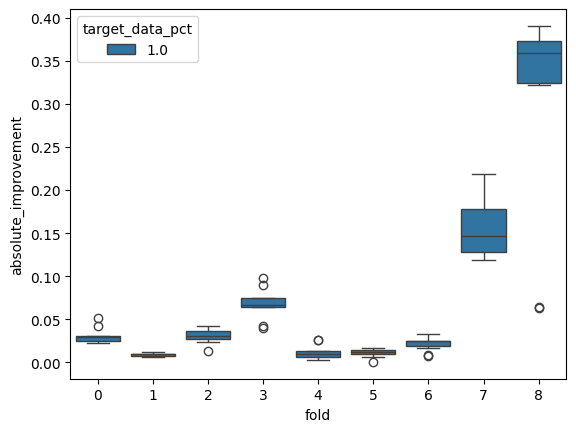

In [14]:
df_best = df.copy()
df_best = df_best[df_best['mode'] != 'base']
df_best = df_best.groupby(['experiment']).filter(lambda x: len(x) == 9)
print(df_best['test_f1'].mean())
df_best = df_best.groupby(['experiment']).filter(lambda x: (x['absolute_improvement'] > 0).all())
print(df_best['test_f1'].mean())
df_best = df_best[df_best['target_data_pct'] == 1.0] 
print(df_best['test_f1'].mean())
sns.boxplot(data=df_best,x='fold',y='absolute_improvement',hue='target_data_pct')
best_experiment = df_best.groupby(['experiment'])['absolute_improvement_val'].mean().idxmax()
df_best[df_best['experiment'] == best_experiment].sort_values(by='fold')

In [ ]:

# best_experiment = df_best.groupby(['experiment'])['absolute_improvement_val'].median().idxmax()
# df_best[df_best['experiment'] == best_experiment]
sns.boxplot(data=df_best,x='fold',y='absolute_improvement',hue='target_data_pct')

In [ ]:
df.groupby(['experiment'])['best_val_f1'].mean()

In [ ]:
best_df = df[(df['early_stopping_patience_target'] == best_early_stopping_patience_target) & (df['batch_size'] == best_batch_size)]
sns.boxplot(data=best_df,y='test_f1') # boxplot of test f1 for best hyperparameters, distribution is across random seeds

In [ ]:
# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        for epoch, f1 in enumerate(losses['val_f1']):
            curve_data.append({
                'epoch': epoch,
                'train_f1': losses['train_f1'][epoch],
                'train_loss': losses['train_loss'][epoch],
                'val_f1': f1,
                'val_loss': losses['val_loss'][epoch],
                **hyperparameters
            })

curve_df = pd.DataFrame(curve_data)

In [ ]:
plt.figure(figsize=(12, 6))
# sns.lineplot(data=curve_df, x='epoch', y='train_f1')
sns.lineplot(data=curve_df, x='epoch', y='val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()

In [ ]:
# Create combined dataset
best_by_loss = df.sort_values(by='best_val_loss', ascending=True).head(10).copy()
best_by_loss['selection_method'] = 'Best by Val Loss'

best_by_f1 = df.sort_values(by='best_val_f1', ascending=False).head(10).copy()
best_by_f1['selection_method'] = 'Best by Val F1'

combined_df = pd.concat([best_by_loss, best_by_f1])

# Single boxplot with hue
sns.boxplot(data=combined_df, x='selection_method', y='test_f1', hue='early_stopping_patience_target')
plt.title('Test F1 Comparison: Best Hyperparameters by Different Metrics')
plt.show()

In [ ]:
sns.boxplot(data=df,y='best_val_f1', hue='early_stopping_patience_target')

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 8), dpi=300)

sns.boxplot(data=df, x='mode', y='test_f1', ax=ax[0,0])
sns.boxplot(data=df, x='target_data_pct', y='test_f1', ax=ax[0,1])
sns.boxplot(data=df, x='fold', y='test_f1', ax=ax[0,2])

sns.boxplot(data=df, x='mode', y='absolute_improvement', ax=ax[1,0])
sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement', ax=ax[1,1])
sns.boxplot(data=df, x='fold', y='absolute_improvement', ax=ax[1,2])

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(21, 8), dpi=300)

sns.boxplot(data=df, x='mode', y='test_f1', hue='fold', ax=ax[0,0])
sns.boxplot(data=df, x='target_data_pct', y='test_f1', hue='mode', ax=ax[0,1])
sns.boxplot(data=df, x='fold', y='test_f1', hue='mode', ax=ax[0,2])

sns.boxplot(data=df, x='mode', y='absolute_improvement', ax=ax[1,0])
sns.boxplot(data=df, x='target_data_pct', y='absolute_improvement', ax=ax[1,1])
sns.boxplot(data=df, x='fold', y='absolute_improvement', hue='target_data_pct', ax=ax[1,2])

In [ ]:
def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']

# Do similar for difference between target only fine tuning and full fine tuning paired by base experiment
# Create a function to get the performance for each fine-tuning mode
def get_finetune_comparison(df):
    # Filter to only fine-tuning experiments (not base)
    finetune_df = df[df['mode'].isin(['target_only_fine_tuning', 'full_fine_tuning'])].copy()
    
    # Pivot to get both modes side by side for each base experiment
    comparison_df = finetune_df.pivot_table(
        values='test_f1', 
        index=['base_experiment_prefix', 'fold'], 
        columns='mode', 
        aggfunc='first'
    ).reset_index()
    
    # Calculate the difference (full - target_only)
    comparison_df['full_vs_target_only_diff'] = (
        comparison_df['full_fine_tuning'] - comparison_df['target_only_fine_tuning']
    )
    
    return comparison_df

# Get the comparison
finetune_comparison = get_finetune_comparison(df)

# Add this back to the main dataframe
df = df.merge(
    finetune_comparison[['base_experiment_prefix', 'fold', 'full_vs_target_only_diff']], 
    on=['base_experiment_prefix', 'fold'], 
    how='left'
)

# Now you can visualize which approach is better
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Box plot of the difference
sns.boxplot(data=finetune_comparison, y='full_vs_target_only_diff', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Full Fine-tuning vs Target-only\n(Positive = Full Better)')
axes[0].set_ylabel('Performance Difference')

# Side-by-side comparison
finetune_melted = finetune_comparison.melt(
    id_vars=['base_experiment_prefix', 'fold'],
    value_vars=['target_only_fine_tuning', 'full_fine_tuning'],
    var_name='fine_tuning_mode',
    value_name='test_f1'
)
sns.boxplot(data=finetune_melted, x='fine_tuning_mode', y='test_f1', ax=axes[1])
axes[1].set_title('Performance by Fine-tuning Mode')

# Scatter plot showing paired comparison
sns.scatterplot(
    data=finetune_comparison, 
    x='target_only_fine_tuning', 
    y='full_fine_tuning',
    ax=axes[2]
)
axes[2].plot([0, 1], [0, 1], 'r--', alpha=0.7)  # Diagonal line
axes[2].set_title('Paired Comparison\n(Above line = Full Better)')
axes[2].set_xlabel('Target-only Fine-tuning F1')
axes[2].set_ylabel('Full Fine-tuning F1')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of Fine-tuning Comparison:")
print(f"Mean difference (Full - Target-only): {finetune_comparison['full_vs_target_only_diff'].mean():.4f}")
print(f"Std of difference: {finetune_comparison['full_vs_target_only_diff'].std():.4f}")
print(f"Full fine-tuning better in {(finetune_comparison['full_vs_target_only_diff'] > 0).sum()} out of {len(finetune_comparison)} cases")

In [ ]:
df_plot = df.copy()
df = df[df['mode'] != 'base']  # Exclude base for this plot because it has no target_data_pct
sns.boxplot(data=df, x='mode', y='test_f1', hue='target_data_pct')

In [ ]:
df_plot = df.copy()
sns.boxplot(data=df_plot, x='fold', y='best_target_model_target_val_f1', hue='mode')

In [ ]:
df_plot = df.copy()
# df_plot = df_plot[df_plot['mode'] == 'full_fine_tuning']
df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
sns.boxplot(data=df_plot, x='metric', y='value', hue='mode')

In [ ]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
# df_plot = df_plot[df_plot['n_base_participants'] == 6]
df_plot = df_plot.melt(value_vars=['best_base_model_target_test_f1','best_target_model_target_test_f1'],id_vars=['fold','batch_size','target_data_pct','n_base_participants','mode'], var_name='metric', value_name='value')
df_plot
sns.boxplot(data=df_plot, x='fold', y='value', hue='metric')

In [ ]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1')

In [ ]:
sns.boxplot(data=df, x='mode', y='best_target_model_target_test_f1', hue='target_data_pct')

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12,10))
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_loss', ax=ax[0,0])
ax[0,0].set_yscale('log')
sns.boxplot(data=df, x='target_data_pct', y='best_target_model_target_val_f1', ax=ax[1,0])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_f1', hue='target_data_pct', ax=ax[0,1])
sns.boxplot(data=df, x='batch_size', y='best_target_model_target_val_loss', hue='target_data_pct', ax=ax[1,1])

In [ ]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
# df_plot = df_plot[df_plot['target_data_pct'] == 1]
sns.boxplot(data=df_plot, x='n_base_participants', y='best_target_model_target_test_f1')

In [ ]:
df

In [ ]:
df[df['experiment'] == 'base_27ae31959dda4c42']

In [ ]:
df.loc[df['mode'] == 'base','test_f1'].mean()

In [ ]:
df.groupby('experiment')['test_f1'].mean().sort_values(ascending=False)

In [ ]:
best_model_hash = df.groupby('hyperparameter_hash')['best_target_model_target_val_f1'].mean().sort_values(ascending=False).keys()[0]
print(best_model_hash)
df_metrics = df[df['hyperparameter_hash'] == best_model_hash].copy()
# Compute Metrics For Paper
display(df_metrics)
df_metrics = df_metrics[['fold','best_base_model_target_test_f1','best_target_model_target_test_f1']]
df_metrics.sort_values('fold', inplace=True)
# Add Absolute Improvement
df_metrics['absolute_improvement'] = df_metrics['best_target_model_target_test_f1'] - df_metrics['best_base_model_target_test_f1']
# Add Relative Improvement
df_metrics['relative_improvement'] = df_metrics['absolute_improvement'] / df_metrics['best_base_model_target_test_f1']
# Add Room For Improvement Metric
df_metrics['room_for_improvement'] = (1 - df_metrics['best_base_model_target_test_f1'])
df_metrics['room_for_improvement_pct'] = df_metrics['absolute_improvement'] / df_metrics['room_for_improvement']

In [ ]:
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1,evaluate
from sklearn.metrics import classification_report
from lib.train_utils import random_subsample
device = 'cpu'

# Load Model From Best Model Hash
# You can change this to load a different model if you want to inspect it
best_model_dir = [d for d in os.listdir(experiments_dir) if best_model_hash in d][0]
print(f'Loading model from {best_model_dir}')

run_dirs = os.listdir(f'{experiments_dir}/{best_model_dir}')
print(f'Runs: {run_dirs}')

df_metrics['best_target_model_target_test_precision'] = 0.0
df_metrics['best_target_model_target_test_recall'] = 0.0

for run_dir in run_dirs:
    print(f'Loading model from {run_dir}')
    best_base_model_path = f'{experiments_dir}/{best_model_dir}/{run_dir}/best_base_model.pt'

    criterion = nn.BCEWithLogitsLoss()
    hyperparameters = json.load(open(f'{experiments_dir}/{best_model_dir}/{run_dir}/hyperparameters.json'))
    target_participant = hyperparameters['target_participant']
    data_path = hyperparameters['data_path']
    batch_size = hyperparameters['batch_size']
    fold = hyperparameters['fold']
    print(f'Loading data from {data_path} for target participant {target_participant}')
    target_train_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_train.pt'))
    target_val_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_val.pt'))
    target_test_dataset = TensorDataset(*torch.load(f'{data_path}/{target_participant}_test.pt'))

    # Subsample target training data if specified
    target_data_pct = hyperparameters['target_data_pct']
    if target_data_pct < 1.0:
        print(f'Target train dataset size: {len(target_train_dataset)}')
        target_train_dataset = random_subsample(target_train_dataset, target_data_pct)
        print(f'Target train dataset size: {len(target_train_dataset)}')

    print(f'Target val dataset size: {len(target_val_dataset)}')
    target_val_dataset = random_subsample(target_val_dataset, .1)
    print(f'Target val dataset size: {len(target_val_dataset)}')

    target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True)
    target_valloader = DataLoader(target_val_dataset, batch_size=batch_size, shuffle=False)
    target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=False)

    model = TestModel()
    print(f'Loading base model from {best_base_model_path}')
    model.load_state_dict(torch.load(best_base_model_path, map_location='cpu'))
    model.to(device)

    test_loss, test_f1 = compute_loss_and_f1(model, target_testloader, criterion, device=device)
    y_true,y_pred = evaluate(model, target_testloader, device=device)

    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']

    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_precision'] = precision
    df_metrics.loc[df_metrics['fold'] == fold,'best_target_model_target_test_recall'] = recall

In [ ]:
# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if hyperparameters['mode'] != 'full_fine_tuning':
            continue
        
        for epoch, f1 in enumerate(losses['target val f1']):
            curve_data.append({
                'epoch': epoch,
                'target_val_f1': f1,
                'fold': run
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='target_val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()